In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.datasets.mnist import FashionMNIST
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
class FashionMNISTPairs(Dataset):
    def __init__(self, dataset: FashionMNIST, num_pairs_per_epoch=100000):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Convert 1 channel to 3 channels
            transforms.Resize((224, 224)), # Resize to the size expected by ResNet18
            transforms.ToTensor()
        ])
        self.length = len(dataset)
        self.num_pairs_per_epoch = num_pairs_per_epoch
        self.pairs_indices = self.generate_pairs_indices()

    def generate_pairs_indices(self):
        pairs_indices = []
        for _ in range(self.num_pairs_per_epoch):
            i, j = random.sample(range(self.length), 2)
            pairs_indices.append((i, j))
        return pairs_indices

    def __len__(self):
        return self.num_pairs_per_epoch

    def __getitem__(self, idx):
        i, j = self.pairs_indices[idx]
        img1, label1 = self.dataset[i]
        img2, label2 = self.dataset[j]
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1, img2, torch.tensor(label1), torch.tensor(label2), i, j

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(SiameseNetwork, self).__init__()
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc_embedding = nn.Linear(512, 128)  # Embedding layer for Siamese Network
        self.fc_classifier = nn.Linear(128, num_classes)  # Classifier layer

    def forward(self, input1, input2):
        # Feature extraction
        feat1 = self.feature_extractor(input1)
        feat2 = self.feature_extractor(input2)

        # Flatten feature maps
        feat1 = feat1.view(feat1.size(0), -1)
        feat2 = feat2.view(feat2.size(0), -1)

        # Embedding
        emb1 = self.fc_embedding(feat1)
        emb2 = self.fc_embedding(feat2)

        # Classification
        class1 = self.fc_classifier(emb1)
        class2 = self.fc_classifier(emb2)

        return emb1, emb2, class1, class2

    def extract_features(self, input):
        with torch.no_grad():
            features = self.feature_extractor(input)
            features = features.view(features.size(0), -1)
            features = self.fc_embedding(features)
        return features

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [5]:
from tqdm import tqdm

class Trainer:
    def __init__(self, model, contrastive_criterion, classifier_criterion, optimizer, dataloader, device):
        self.model = model
        self.contrastive_criterion = contrastive_criterion
        self.classifier_criterion = classifier_criterion
        self.optimizer = optimizer
        self.dataloader = dataloader
        self.device = device
        self.epoch_losses = []

    def train(self, num_epochs):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for img1, img2, label1, label2, i, j in progress_bar:
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                self.optimizer.zero_grad()
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                # Calculate same_label dynamically
                same_label = (label1 == label2).float()
                
                # Calculate losses
                contrastive_loss = self.contrastive_criterion(emb1, emb2, same_label)
                classifier_loss1 = self.classifier_criterion(class1, label1)
                classifier_loss2 = self.classifier_criterion(class2, label2)
                total_loss = contrastive_loss + classifier_loss1 + classifier_loss2
                
                total_loss.backward()
                self.optimizer.step()
                
                epoch_loss += total_loss.item()
                progress_bar.set_postfix(loss=total_loss.item())
            avg_epoch_loss = epoch_loss / len(self.dataloader)
            self.epoch_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}")

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.epoch_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()


In [38]:
class EmbeddingVisualizer:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def extract_embeddings(self):
        self.model.to(self.device)
        self.model.eval()
        embeddings = []
        labels = []
        indices = []
        wrong_images = []

        with torch.no_grad():
            for img1, img2, label1, label2, i, j in tqdm(self.dataloader, desc="Extracting Embeddings"):
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                embeddings.append(emb1.cpu().numpy())
                embeddings.append(emb2.cpu().numpy())
                labels.append(label1.cpu().numpy())
                labels.append(label2.cpu().numpy())
                indices.extend([i, j])

                # Collect wrong images
                for k in range(label1.size(0)):
                    if label1[k].item() != class1[k].argmax().item():
                        wrong_images.append((img1[k].cpu(), label1[k].cpu(), class1[k].argmax().cpu(), i))
                    if label2[k].item() != class2[k].argmax().item():
                        wrong_images.append((img2[k].cpu(), label2[k].cpu(), class2[k].argmax().cpu(), j))

        embeddings = np.concatenate(embeddings, axis=0)
        labels = np.concatenate(labels, axis=0)
        return embeddings, labels, indices, wrong_images

    def plot_incorrect_images(self, incorrect_images, class_names):
        incorrect_images = [(img.squeeze(0), real, pred) for img, real, pred, idx in incorrect_images if real.item() != pred.item()]
        num_images = len(incorrect_images)
        plt.figure(figsize=(20, 20))

        for i, (img, real, pred) in enumerate(incorrect_images[:25]):
            plt.subplot(5, 5, i + 1)
            plt.imshow(img.permute(1, 2, 0).numpy())
            plt.title(f"Real: {class_names[real.item()]}, Pred: {class_names[pred.item()]}")
            plt.axis('off')

        plt.show()

In [7]:
class Tester:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def test(self):
        self.model.to(self.device)
        self.model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for img1, img2, label1, label2, i, j in tqdm(self.dataloader, desc="Testing"):
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                _, pred1 = torch.max(class1, 1)
                _, pred2 = torch.max(class2, 1)
                
                all_labels.extend(label1.cpu().numpy())
                all_labels.extend(label2.cpu().numpy())
                all_predictions.extend(pred1.cpu().numpy())
                all_predictions.extend(pred2.cpu().numpy())

        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Test Precision: {precision:.2f}")
        print(f"Test Recall: {recall:.2f}")
        print(f"Test F1 Score: {f1:.2f}")

        return accuracy, precision, recall, f1

In [1]:
class KNNPredictor:
    def __init__(self, knn_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors=knn_neighbors)

    def fit(self, train_embeddings, train_labels):
        self.knn.fit(train_embeddings, train_labels)

    def predict(self, embeddings):
        return self.knn.predict(embeddings)

    def evaluate(self, true_labels, predicted_labels):
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        return accuracy, precision, recall, f1

    def get_wrong_indices(self, true_labels, predicted_labels, indices):
        wrong_indices = [index for index, (true, pred) in zip(indices, zip(true_labels, predicted_labels)) if true != pred]
        return wrong_indices

    def run(self, train_embeddings, train_labels, test_embeddings, test_labels, train_indices, test_indices):
        # Train KNN on training embeddings
        self.fit(train_embeddings, train_labels)

        # Predict train and test data using KNN
        train_predictions = self.predict(train_embeddings)
        test_predictions = self.predict(test_embeddings)

        # Evaluate the predictions
        print("Train Data Evaluation:")
        self.evaluate(train_labels, train_predictions)
        
        print("\nTest Data Evaluation:")
        self.evaluate(test_labels, test_predictions)

        # Get wrong indices for train and test data
        train_wrong_indices = self.get_wrong_indices(train_labels, train_predictions, train_indices)
        test_wrong_indices = self.get_wrong_indices(test_labels, test_predictions, test_indices)

        return train_wrong_indices, test_wrong_indices

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print('using device:', device)
# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

train_pairs_dataset = FashionMNISTPairs(train_dataset, num_pairs_per_epoch=50000)
test_pairs_dataset = FashionMNISTPairs(test_dataset, num_pairs_per_epoch=5000)

train_loader = DataLoader(train_pairs_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_pairs_dataset, batch_size=8, shuffle=False)

# Initialize model, loss function, and optimizer
model = SiameseNetwork()
contrastive_criterion = ContrastiveLoss()
classifier_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using device: cuda


In [12]:
state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(state, 'model1.pth')

starting training


Epoch 1/40: 100%|██████████| 196/196 [03:14<00:00,  1.01it/s, loss=4.32]


Epoch 1/40, Loss: 5.078382063885124


Epoch 2/40: 100%|██████████| 196/196 [03:04<00:00,  1.06it/s, loss=3.09]


Epoch 2/40, Loss: 3.7620918288522835


Epoch 3/40: 100%|██████████| 196/196 [02:58<00:00,  1.10it/s, loss=2.26]


Epoch 3/40, Loss: 2.7037532901277346


Epoch 4/40: 100%|██████████| 196/196 [03:04<00:00,  1.06it/s, loss=1.82]


Epoch 4/40, Loss: 2.035053025703041


Epoch 5/40: 100%|██████████| 196/196 [03:07<00:00,  1.05it/s, loss=1.58]


Epoch 5/40, Loss: 1.655828365257808


Epoch 6/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=1.28]


Epoch 6/40, Loss: 1.3782072705881936


Epoch 7/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=1.06]


Epoch 7/40, Loss: 1.1945111088606777


Epoch 8/40: 100%|██████████| 196/196 [03:04<00:00,  1.06it/s, loss=1.03] 


Epoch 8/40, Loss: 1.0305002173598932


Epoch 9/40: 100%|██████████| 196/196 [03:04<00:00,  1.06it/s, loss=0.877]


Epoch 9/40, Loss: 0.9438765894393532


Epoch 10/40: 100%|██████████| 196/196 [03:07<00:00,  1.05it/s, loss=0.808]


Epoch 10/40, Loss: 0.8296986602398814


Epoch 11/40: 100%|██████████| 196/196 [03:05<00:00,  1.06it/s, loss=0.805]


Epoch 11/40, Loss: 0.7837948461576384


Epoch 12/40: 100%|██████████| 196/196 [03:07<00:00,  1.04it/s, loss=0.756]


Epoch 12/40, Loss: 0.7293924117574886


Epoch 13/40: 100%|██████████| 196/196 [02:57<00:00,  1.11it/s, loss=0.7]  


Epoch 13/40, Loss: 0.6712878145733658


Epoch 14/40: 100%|██████████| 196/196 [03:02<00:00,  1.07it/s, loss=0.632]


Epoch 14/40, Loss: 0.6647253632545471


Epoch 15/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.563]


Epoch 15/40, Loss: 0.6562607741477539


Epoch 16/40: 100%|██████████| 196/196 [03:01<00:00,  1.08it/s, loss=0.587]


Epoch 16/40, Loss: 0.5844324918425813


Epoch 17/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.51] 


Epoch 17/40, Loss: 0.5306792018973098


Epoch 18/40: 100%|██████████| 196/196 [03:02<00:00,  1.07it/s, loss=0.475]


Epoch 18/40, Loss: 0.49122887302418144


Epoch 19/40: 100%|██████████| 196/196 [03:00<00:00,  1.09it/s, loss=0.454]


Epoch 19/40, Loss: 0.460012891006713


Epoch 20/40: 100%|██████████| 196/196 [03:05<00:00,  1.05it/s, loss=0.433]


Epoch 20/40, Loss: 0.44183288210508775


Epoch 21/40: 100%|██████████| 196/196 [03:06<00:00,  1.05it/s, loss=0.425]


Epoch 21/40, Loss: 0.41590196289578263


Epoch 22/40: 100%|██████████| 196/196 [03:05<00:00,  1.06it/s, loss=0.385]


Epoch 22/40, Loss: 0.3909449607742076


Epoch 23/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.367]


Epoch 23/40, Loss: 0.37702619330007203


Epoch 24/40: 100%|██████████| 196/196 [02:59<00:00,  1.09it/s, loss=1.02] 


Epoch 24/40, Loss: 4.135631721086648


Epoch 25/40: 100%|██████████| 196/196 [03:05<00:00,  1.06it/s, loss=0.806]


Epoch 25/40, Loss: 0.858865925548028


Epoch 26/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.613]


Epoch 26/40, Loss: 0.6480773380216287


Epoch 27/40: 100%|██████████| 196/196 [02:57<00:00,  1.11it/s, loss=0.523]


Epoch 27/40, Loss: 0.5309555243168559


Epoch 28/40: 100%|██████████| 196/196 [02:59<00:00,  1.09it/s, loss=0.512]


Epoch 28/40, Loss: 0.45437027650828266


Epoch 29/40: 100%|██████████| 196/196 [03:02<00:00,  1.07it/s, loss=0.443]


Epoch 29/40, Loss: 0.42723379527427713


Epoch 30/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.407]


Epoch 30/40, Loss: 0.4015829388280304


Epoch 31/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.437]


Epoch 31/40, Loss: 0.38840704502499834


Epoch 32/40: 100%|██████████| 196/196 [03:04<00:00,  1.06it/s, loss=0.342]


Epoch 32/40, Loss: 0.3799713606737098


Epoch 33/40: 100%|██████████| 196/196 [02:55<00:00,  1.12it/s, loss=0.394]


Epoch 33/40, Loss: 0.3754070244577466


Epoch 34/40: 100%|██████████| 196/196 [02:57<00:00,  1.11it/s, loss=0.349]


Epoch 34/40, Loss: 0.37053063755132715


Epoch 35/40: 100%|██████████| 196/196 [02:57<00:00,  1.11it/s, loss=0.397]


Epoch 35/40, Loss: 0.36587589066855764


Epoch 36/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.607]


Epoch 36/40, Loss: 0.4162287030901228


Epoch 37/40: 100%|██████████| 196/196 [03:02<00:00,  1.07it/s, loss=0.429]


Epoch 37/40, Loss: 0.4728355433563797


Epoch 38/40: 100%|██████████| 196/196 [03:03<00:00,  1.07it/s, loss=0.37] 


Epoch 38/40, Loss: 0.38473644502917115


Epoch 39/40: 100%|██████████| 196/196 [02:57<00:00,  1.10it/s, loss=0.369]


Epoch 39/40, Loss: 0.3652067871726289


Epoch 40/40: 100%|██████████| 196/196 [02:56<00:00,  1.11it/s, loss=0.36] 

Epoch 40/40, Loss: 0.35473887667972215


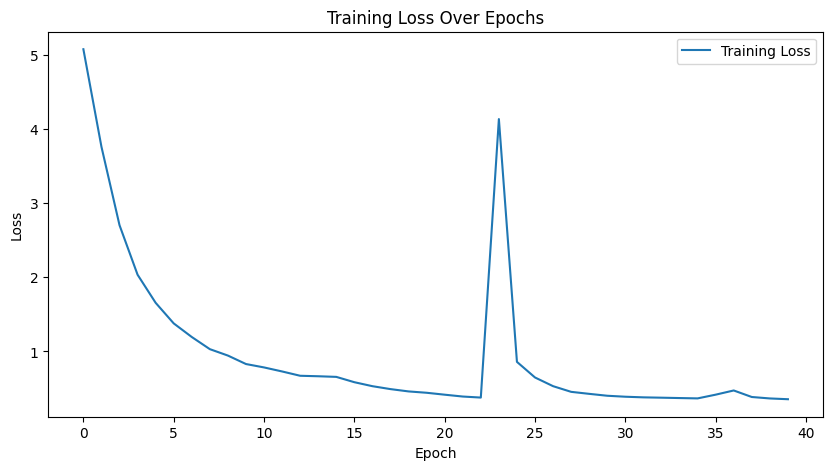

In [9]:
# Train the model
print('starting training')
trainer = Trainer(model,contrastive_criterion, classifier_criterion, optimizer, train_loader, device)
trainer.train(num_epochs=40)

# Plot the training loss
trainer.plot_losses()

In [10]:
# Test the model
print('starting testing')
tester = Tester(model, test_loader, device)
tester.test()

starting testing


Testing: 100%|██████████| 625/625 [00:08<00:00, 76.28it/s]


Test Accuracy: 94.09%
Test Precision: 0.94
Test Recall: 0.94
Test F1 Score: 0.94


(0.9409, 0.9408705565267557, 0.9409, 0.9408300985404161)

In [39]:
# Visualize embeddings
visualizer = EmbeddingVisualizer(model, test_loader, device)
embeddings, real_labels, predicted_labels, incorrect_images = visualizer.extract_embeddings()
# visualizer.visualize(embeddings, real_labels, predicted_labels)

Extracting Embeddings: 100%|██████████| 625/625 [00:08<00:00, 75.28it/s]


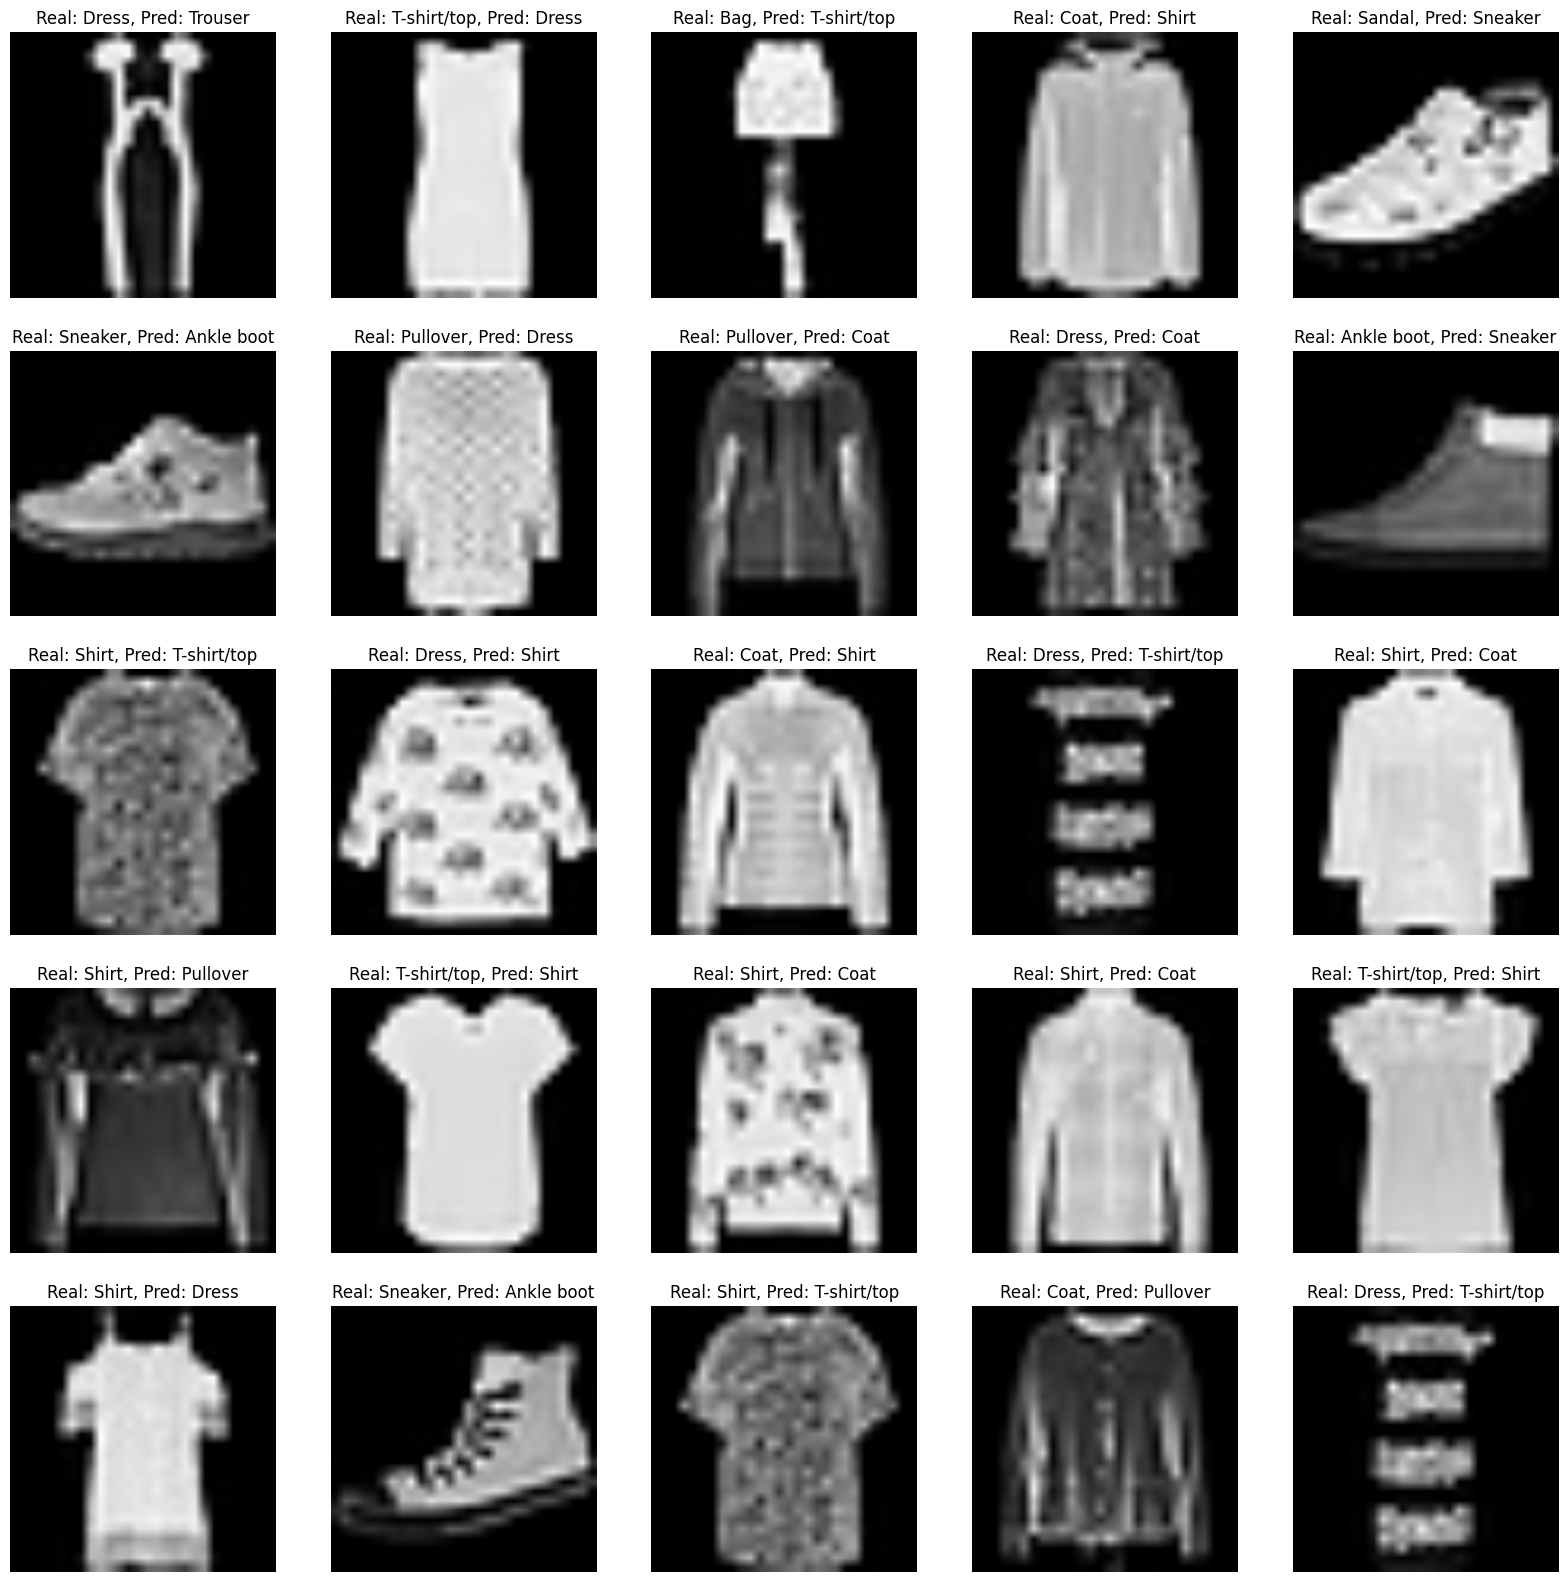

In [42]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
visualizer.plot_incorrect_images(incorrect_images, class_names)

In [44]:
train_visualizer = EmbeddingVisualizer(model, train_loader, device)
train_embeddings, train_labels, train_indices, train_wrong_images = train_visualizer.extract_embeddings()

# Extract embeddings from test data
test_visualizer = EmbeddingVisualizer(model, test_loader, device)
test_embeddings, test_labels, test_indices, test_wrong_images = test_visualizer.extract_embeddings()

# Initialize and run KNNPredictor
knn_predictor = KNNPredictor(knn_neighbors=5)
train_wrong_indices, test_wrong_indices = knn_predictor.run(
    train_embeddings, train_labels, test_embeddings, test_labels, train_indices, test_indices
)

# Print the indices of wrong predictions
print("Indices of wrong predictions in train data:", train_wrong_indices)
print("Indices of wrong predictions in test data:", test_wrong_indices)

# Visualize incorrect predictions from the KNN results
test_visualizer.plot_incorrect_images(test_wrong_images, class_names)

Extracting Embeddings: 100%|██████████| 625/625 [00:08<00:00, 74.14it/s]
